## 1. Data Loading & Cleaning

In [1]:
!pip -q install yfinance pandas numpy matplotlib

In [2]:
import os
import pandas as pd
import yfinance as yf

TICKERS = ["AAPL", "MSFT", "NVDA", "SPY"]
START_DATE = "2019-01-01"
END_DATE = "2024-10-01"

df = yf.download(
    tickers=TICKERS,
    start=START_DATE,
    end=END_DATE,
    interval="1d",
    group_by="ticker",
    auto_adjust=False,
    progress=False,
    threads=True
)

df.head()

Ticker            MSFT                                                 \
Price             Open        High         Low       Close  Adj Close   
Date                                                                    
2019-01-02   99.550003  101.750000   98.940002  101.120003  94.612595   
2019-01-03  100.099998  100.190002   97.199997   97.400002  91.132004   
2019-01-04   99.720001  102.510002   98.930000  101.930000  95.370476   
2019-01-07  101.639999  103.269997  100.980003  102.059998  95.492111   
2019-01-08  103.040001  103.970001  101.709999  102.800003  96.184479   

Ticker                       SPY                                      ...  \
Price         Volume        Open        High         Low       Close  ...   
Date                                                                  ...   
2019-01-02  35329300  245.979996  251.210007  245.949997  250.179993  ...   
2019-01-03  42579100  248.229996  248.570007  243.669998  244.210007  ...   
2019-01-04  44060600  247.589996  253.110001  247.169998  252.389999  ...   
2019-01-07  35656100  252.690002  255.949997  251.690002  254.380005  ...   
2019-01-08  31514400  256.820007  257.309998  254.000000  256.769989  ...   

Ticker         NVDA                                     AAPL             \
Price           Low    Close Adj Close     Volume       Open       High   
Date                                                                      
2019-01-02  3.25125  3.40550  3.377167  508752000  38.722500  39.712502   
2019-01-03  3.19225  3.19975  3.173128  705552000  35.994999  36.430000   
2019-01-04  3.24250  3.40475  3.376423  585620000  36.132500  37.137501   
2019-01-07  3.41075  3.58500  3.555173  709160000  37.174999  37.207500   
2019-01-08  3.42250  3.49575  3.466665  786016000  37.389999  37.955002   

Ticker                                                  
Price             Low      Close  Adj Close     Volume  
Date                                                    
2019-01-02  38.557499  39.480000  37.538818  148158800  
2019-01-03  35.500000  35.547501  33.799675  365248800  
2019-01-04  35.950001  37.064999  35.242561  234428400  
2019-01-07  36.474998  36.982498  35.164108  219111200  
2019-01-08  37.130001  37.687500  35.834446  164101200  

[5 rows x 24 columns]

In [3]:
import pandas as pd

tidy = df.copy()

# If multiple tickers were downloaded, columns are multi-index (Ticker, Field)
if isinstance(tidy.columns, pd.MultiIndex):
    tidy = tidy.stack(level=0).reset_index()
    tidy.rename(columns={"level_1": "Ticker"}, inplace=True)
    tidy.columns = [c.lower().replace(" ", "_") for c in tidy.columns]
else:
    # Single ticker case
    tidy = tidy.reset_index()
    tidy["ticker"] = TICKERS[0]
    tidy.columns = [c.lower().replace(" ", "_") for c in tidy.columns]

# Keep only what we need for the analysis
tidy = tidy[["date", "ticker", "close", "volume"]].dropna()
tidy = tidy.sort_values(["ticker", "date"]).reset_index(drop=True)

tidy.head()

/tmp/ipython-input-4278643945.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tidy = tidy.stack(level=0).reset_index()


,date,ticker,close,volume
0,2019-01-02,AAPL,39.480000,148158800
1,2019-01-03,AAPL,35.547501,365248800
2,2019-01-04,AAPL,37.064999,234428400
3,2019-01-07,AAPL,36.982498,219111200
4,2019-01-08,AAPL,37.687500,164101200


## 2. Normalized Price Comparison

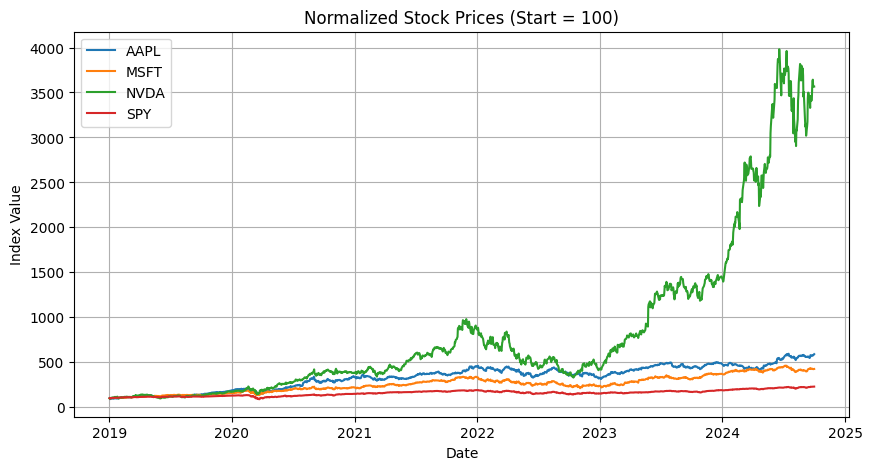

In [4]:
import matplotlib.pyplot as plt

# Pivot so each ticker is its own column
price_pivot = tidy.pivot(index="date", columns="ticker", values="close")

# Normalize prices so all start at 100
normalized = price_pivot / price_pivot.iloc[0] * 100

plt.figure(figsize=(10, 5))
for col in normalized.columns:
    plt.plot(normalized.index, normalized[col], label=col)

plt.title("Normalized Stock Prices (Start = 100)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.grid(True)
plt.show()

**Insight:**  
NVDA experienced the strongest relative growth over the analyzed period, outperforming AAPL, MSFT, and SPY after normalizing starting prices.

## 3. Volatility Analysis

In [9]:
import numpy as np

# Calculate daily returns
tidy["return"] = tidy.groupby("ticker")["close"].pct_change()

# Annualized volatility
volatility = (
    tidy.groupby("ticker")["return"]
    .std()
    * np.sqrt(252)
).sort_values(ascending=False)

volatility

,return
ticker,
NVDA,0.524529
AAPL,0.313046
MSFT,0.293076
SPY,0.201733


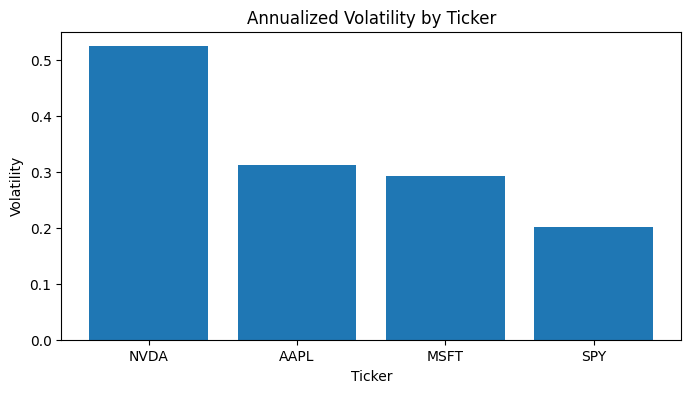

In [10]:
plt.figure(figsize=(8, 4))
plt.bar(volatility.index, volatility.values)
plt.title("Annualized Volatility by Ticker")
plt.xlabel("Ticker")
plt.ylabel("Volatility")
plt.show()

**Insight:**  
While NVDA delivered the highest returns, it also showed the highest annualized volatility, highlighting a trade-off between growth and risk.

## 4. Drawdown Analysis

In [11]:
# Drawdown per ticker: % drop from the running peak
tidy["peak"] = tidy.groupby("ticker")["close"].cummax()
tidy["drawdown"] = (tidy["close"] - tidy["peak"]) / tidy["peak"]

# Max drawdown (most negative) per ticker
max_drawdown = tidy.groupby("ticker")["drawdown"].min().sort_values()

max_drawdown


,drawdown
ticker,
NVDA,-0.663621
MSFT,-0.375565
SPY,-0.341047
AAPL,-0.314273


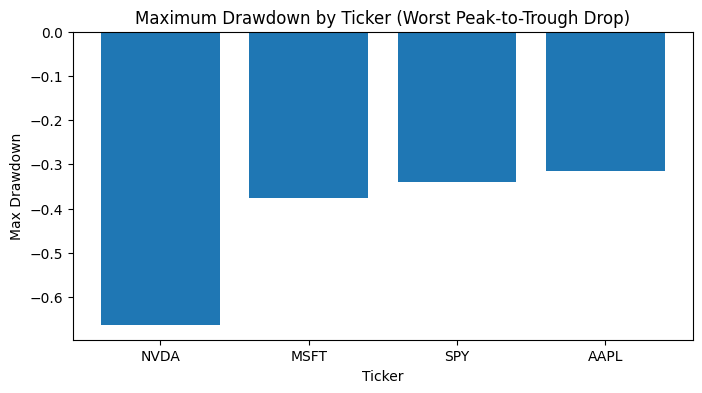

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(max_drawdown.index, max_drawdown.values)
plt.title("Maximum Drawdown by Ticker (Worst Peak-to-Trough Drop)")
plt.xlabel("Ticker")
plt.ylabel("Max Drawdown")
plt.show()

**Insight:**  
Maximum drawdown captures the worst peak-to-trough decline. NVDA can still experience deeper drawdowns, meaning larger temporary losses during downturns compared to more diversified assets like SPY.

## 5. Volume Spikes & Returns


In [13]:
# Identify volume spikes (top 10% volume days per ticker)
tidy["volume_threshold"] = tidy.groupby("ticker")["volume"].transform(
    lambda x: x.quantile(0.90)
)
tidy["is_volume_spike"] = tidy["volume"] >= tidy["volume_threshold"]

# Compute next-day return
tidy["next_day_return"] = tidy.groupby("ticker")["return"].shift(-1)

# Compare next-day returns after spike vs normal days
volume_effect = (
    tidy.groupby(["ticker", "is_volume_spike"])["next_day_return"]
    .agg(["mean", "median", "count"])
    .reset_index()
)

volume_effect

,ticker,is_volume_spike,mean,median,count
0,AAPL,False,0.001287,0.001417,1300
1,AAPL,True,0.002648,0.002261,145
2,MSFT,False,0.001073,0.000980,1300
3,MSFT,True,0.002068,0.002259,145
4,NVDA,False,0.003130,0.003365,1300
5,NVDA,True,0.002012,-0.000992,145
6,SPY,False,0.000622,0.000801,1300
7,SPY,True,0.000960,0.002311,145


In [14]:
for t in tidy["ticker"].unique():
    sub = volume_effect[volume_effect["ticker"] == t]
    spike = sub[sub["is_volume_spike"] == True]["mean"].values[0]
    normal = sub[sub["is_volume_spike"] == False]["mean"].values[0]
    print(f"{t}: next-day mean return | spike={spike:.4%} vs normal={normal:.4%}")

AAPL: next-day mean return | spike=0.2648% vs normal=0.1287%
MSFT: next-day mean return | spike=0.2068% vs normal=0.1073%
NVDA: next-day mean return | spike=0.2012% vs normal=0.3130%
SPY: next-day mean return | spike=0.0960% vs normal=0.0622%


**Insight:**  
The effect of volume spikes on next-day returns varies by asset. While AAPL, MSFT, and SPY tend to show slightly higher average returns following high-volume days, NVDA exhibits weaker post-spike performance, suggesting potential overreaction or mean reversion in more volatile stocks.

## 6. Correlation Analysis


In [15]:
# Pivot daily returns so each ticker is a column
returns_pivot = tidy.pivot(index="date", columns="ticker", values="return").dropna()

# Correlation matrix
correlation_matrix = returns_pivot.corr()
correlation_matrix

ticker,AAPL,MSFT,NVDA,SPY
ticker,,,,
AAPL,1.000000,0.737302,0.610386,0.786087
MSFT,0.737302,1.000000,0.676637,0.819625
NVDA,0.610386,0.676637,1.000000,0.696198
SPY,0.786087,0.819625,0.696198,1.000000


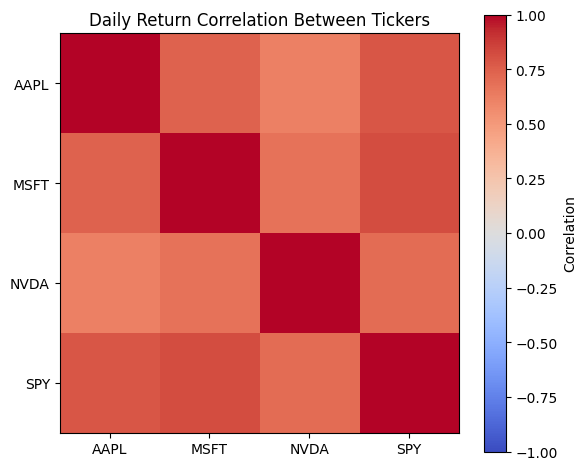

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.imshow(correlation_matrix.values, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)

plt.title("Daily Return Correlation Between Tickers")
plt.tight_layout()
plt.show()

**Insight:**  
SPY shows moderate positive correlation with large-cap technology stocks, while individual stocks such as NVDA exhibit lower pairwise correlations. This suggests that diversification across tickers can reduce portfolio risk, even within the same market.

## 7. Insights & Takeaways


- NVDA delivered the strongest long-term price growth among the analyzed tickers, but also exhibited the highest volatility and deepest drawdowns, highlighting the trade-off between return and risk.
- SPY showed more stable performance with lower volatility and smaller drawdowns, reflecting the benefits of diversification.
- Volume spikes were followed by different next-day return behavior depending on the asset, with more volatile stocks like NVDA showing weaker post-spike performance compared to large-cap and diversified assets.
- Correlation analysis revealed moderate positive relationships between SPY and large-cap technology stocks, while individual stocks maintained lower pairwise correlations.
- These results demonstrate how risk, return, and market behavior vary across assets, emphasizing the importance of diversification and context when analyzing financial time-series data.